In [1]:
######################################
## running kernel is scvi2, which is scvi-tools conda env
## original code from https://moscot.readthedocs.io/en/latest/notebooks/tutorials/200_temporal_problem.html
######################################
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scvi-tools/bin/python
3.10.15 | packaged by conda-forge | (main, Oct 16 2024, 01:24:24) [GCC 13.3.0]
sys.version_info(major=3, minor=10, micro=15, releaselevel='final', serial=0)


In [2]:
import os
import warnings

import moscot as mt

import moscot.plotting as mpl
from moscot.problems.time import TemporalProblem

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import scanpy as sc

plt.rcParams["legend.scatterpoints"] = 1
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=200)

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warn

In [3]:
mt.__version__, sc.__version__

('0.5.0', '1.10.3')

In [4]:
import h5py

In [5]:
file_path = os.path.join("/groups/tanaka/People/current/jiwang/projects/RA_competence/results/scRNAseq_R16597_mNT_10xmultiome_reseq_20240517/mNTs_multiome_RA_searching_earlyBias/Test_OT",
                         "scRNAseq_RA_d2_d2.5_d3_d4_d5_metacellAnnot_forOTtest_v2.h5ad")
adata = sc.read(file_path, chunk_size=6000)

In [6]:
adata

AnnData object with n_obs × n_vars = 11313 × 20366
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.7', 'seurat_clusters', 'RNA_snn_res.0.5', 'RNA_snn_res.1', 'clusters', 'metacell', 'metacell_label'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [7]:
adata.obs["metacell_label"]

AAACCCATCTGACGCG-1_1_1_1_1_1_1_1_1     d2_1
AAACGAAAGGCTAAAT-1_1_1_1_1_1_1_1_1     d2_2
AAACGCTGTTTGACAC-1_1_1_1_1_1_1_1_1     d2_3
AAACGCTTCATTACCT-1_1_1_1_1_1_1_1_1     d2_4
AAACGCTTCCCAGGCA-1_1_1_1_1_1_1_1_1     d2_4
                                      ...  
TTTGGAGCAACTTGGT-1_2_1                d5_FP
TTTGGTTCAAATCAGA-1_2_1                d5_NP
TTTGGTTCACGACAGA-1_2_1                d5_NP
TTTGGTTTCCCTCATG-1_2_1                d5_NP
TTTGTTGAGACCATGG-1_2_1                d5_NP
Name: metacell_label, Length: 11313, dtype: object

In [8]:
#adata = mt.datasets.pancreas_multiome(rna_only=True, force_download=True)
#endocrine_celltypes = [
#    "Ngn3 low",
#    "Ngn3 high",
#    "Ngn3 high cycling",
#    "Fev+",
#    "Fev+ Alpha",
#    "Fev+ Beta",
#    "Fev+ Delta",
#    "Eps. progenitors",
#    "Alpha",
#    "Beta",
#    "Delta",
#    "Epsilon",
#]
#adata = adata[adata.obs["cell_type"].isin(endocrine_celltypes)].copy()

In [9]:
adata.obs["condition"]

AAACCCATCTGACGCG-1_1_1_1_1_1_1_1_1    day2_beforeRA
AAACGAAAGGCTAAAT-1_1_1_1_1_1_1_1_1    day2_beforeRA
AAACGCTGTTTGACAC-1_1_1_1_1_1_1_1_1    day2_beforeRA
AAACGCTTCATTACCT-1_1_1_1_1_1_1_1_1    day2_beforeRA
AAACGCTTCCCAGGCA-1_1_1_1_1_1_1_1_1    day2_beforeRA
                                          ...      
TTTGGAGCAACTTGGT-1_2_1                      day5_RA
TTTGGTTCAAATCAGA-1_2_1                      day5_RA
TTTGGTTCACGACAGA-1_2_1                      day5_RA
TTTGGTTTCCCTCATG-1_2_1                      day5_RA
TTTGTTGAGACCATGG-1_2_1                      day5_RA
Name: condition, Length: 11313, dtype: object

In [10]:
def adapt_time(x):
    if x["condition"] == "day2_beforeRA":
        return 2
    if x["condition"] == "day2.5_RA":
        return 2.5
    if x["condition"] == "day3_RA.rep1":
        return 3
    if x["condition"] == "day3.5_RA":
        return 3.5
    if x["condition"] == "day4_RA":
        return 4
    if x["condition"] == "day5_RA":
        return 5
    
    raise ValueError

adata.obs["time"] = adata.obs.apply(adapt_time, axis=1).astype("category")

In [11]:
adata.obs["time"]

AAACCCATCTGACGCG-1_1_1_1_1_1_1_1_1    2.0
AAACGAAAGGCTAAAT-1_1_1_1_1_1_1_1_1    2.0
AAACGCTGTTTGACAC-1_1_1_1_1_1_1_1_1    2.0
AAACGCTTCATTACCT-1_1_1_1_1_1_1_1_1    2.0
AAACGCTTCCCAGGCA-1_1_1_1_1_1_1_1_1    2.0
                                     ... 
TTTGGAGCAACTTGGT-1_2_1                5.0
TTTGGTTCAAATCAGA-1_2_1                5.0
TTTGGTTCACGACAGA-1_2_1                5.0
TTTGGTTTCCCTCATG-1_2_1                5.0
TTTGTTGAGACCATGG-1_2_1                5.0
Name: time, Length: 11313, dtype: category
Categories (6, float64): [2.0, 2.5, 3.0, 3.5, 4.0, 5.0]

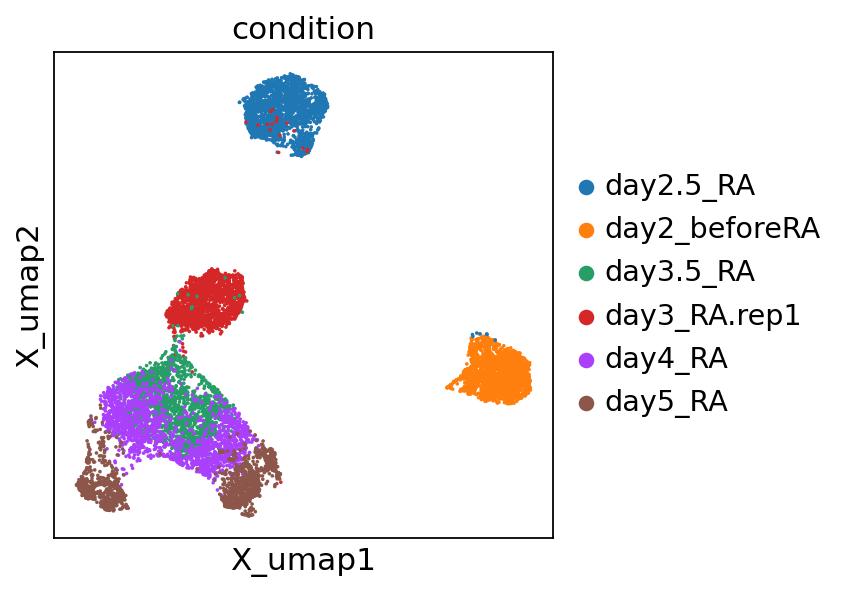

In [12]:
sc.pl.embedding(adata, basis="X_umap", color="condition")

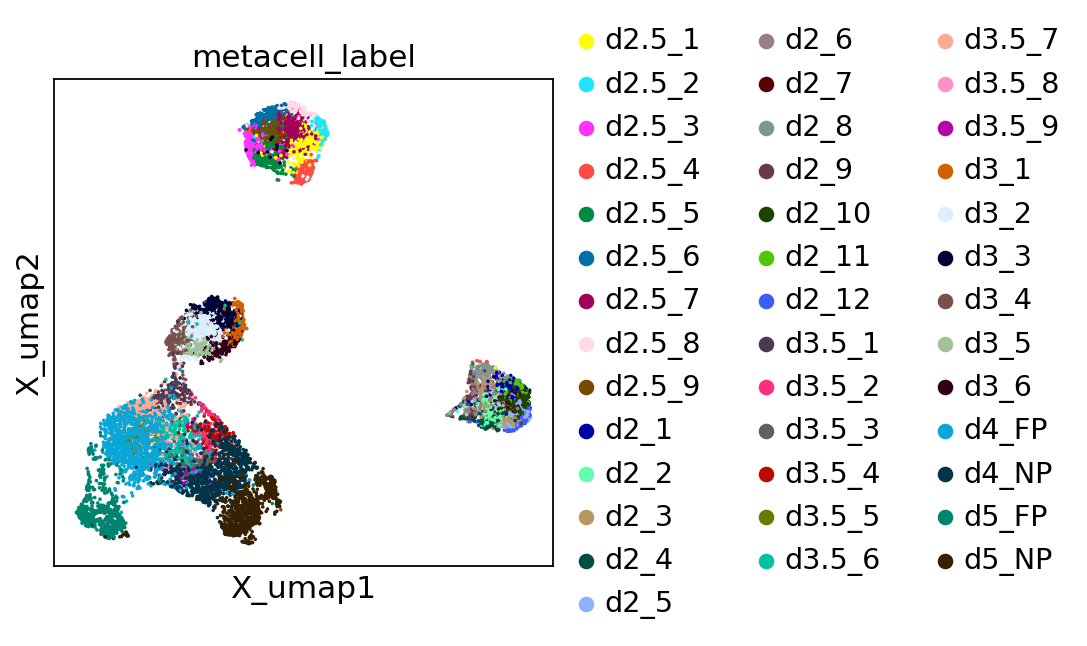

In [13]:
sc.pl.embedding(adata, basis="X_umap", color="metacell_label")

In [14]:
tp0 = TemporalProblem(adata)

In [15]:
tp0 = tp0.prepare(time_key="time", joint_attr="X_pca")

In [16]:
import networkx as nx

dfs = {}
batch_column = "time"
unique_batches = [2, 2.5, 3, 3.5, 4, 5]
for i in range(len(unique_batches) - 1):
    batch1 = unique_batches[i]
    batch2 = unique_batches[i + 1]
    
    indices = np.where(
        (adata.obs[batch_column] == batch1) | (adata.obs[batch_column] == batch2)
    )[0]
    adata_subset = adata[indices]
    
    sc.pp.neighbors(adata_subset, use_rep="X_pca", n_neighbors=30)
    G = nx.from_numpy_array(adata_subset.obsp["connectivities"].todense())
    assert nx.is_connected(G)

    dfs[(batch1, batch2)] = pd.DataFrame(
        index=adata_subset.obs_names,
        columns=adata_subset.obs_names,
        data=adata_subset.obsp["connectivities"].todense().astype("float"),
    )

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
tp0[2, 2.5].set_graph_xy((dfs[2, 2.5]).astype("float"), t=100.0)
tp0[2.5, 3].set_graph_xy((dfs[2.5, 3]).astype("float"), t=100.0)
tp0[3, 3.5].set_graph_xy((dfs[3, 3.5]).astype("float"), t=100.0)
tp0[3.5, 4].set_graph_xy((dfs[3.5, 4]).astype("float"), t=100.0)
tp0[4, 5].set_graph_xy((dfs[4, 5]).astype("float"), t=100.0)

In [18]:
tp0 = tp0.solve(epsilon=1e-3, scale_cost="mean", max_iterations=1e7)

INFO     Solving `5` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1996, 1946)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1794, 1781)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1946, 1824)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1972, 1996)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1824, 1794)].                                  


In [20]:
tp0.save(os.path.join("/groups/tanaka/People/current/jiwang/projects/RA_competence/results/scRNAseq_R16597_mNT_10xmultiome_reseq_20240517/mNTs_multiome_RA_searching_earlyBias/Test_OT",
                         "tp_test_v2.pt"), overwrite=True)

In [21]:
#subset = set(adata[adata.obs["condition"].isin(["day5_RA"])].obs["metacell_label"])
#subset

In [22]:
d5_cluster = list(dict.fromkeys(adata[adata.obs["condition"].isin(["day5_RA"])].obs["metacell_label"]))
d4_cluster = list(dict.fromkeys(adata[adata.obs["condition"].isin(["day4_RA"])].obs["metacell_label"]))
d2_cluster = list(dict.fromkeys(adata[adata.obs["condition"].isin(["day2_beforeRA"])].obs["metacell_label"]))
d2_5_cluster = list(dict.fromkeys(adata[adata.obs["condition"].isin(["day2.5_RA"])].obs["metacell_label"]))
d2_3_cluster = list(dict.fromkeys(adata[adata.obs["condition"].isin(["day3_RA.rep1"])].obs["metacell_label"]))
d2_3_5_cluster = list(dict.fromkeys(adata[adata.obs["condition"].isin(["day3.5_RA"])].obs["metacell_label"]))
d5_cluster

['d5_NP', 'd5_FP']

In [23]:
tp0.sankey(
    source=4,
    target=5,
    source_groups={"metacell_label": d4_cluster},
    target_groups={"metacell_label": d5_cluster},
    threshold=0.0,
    #order_annotations=cluster_subset[::-1],
    normalize=True,
)

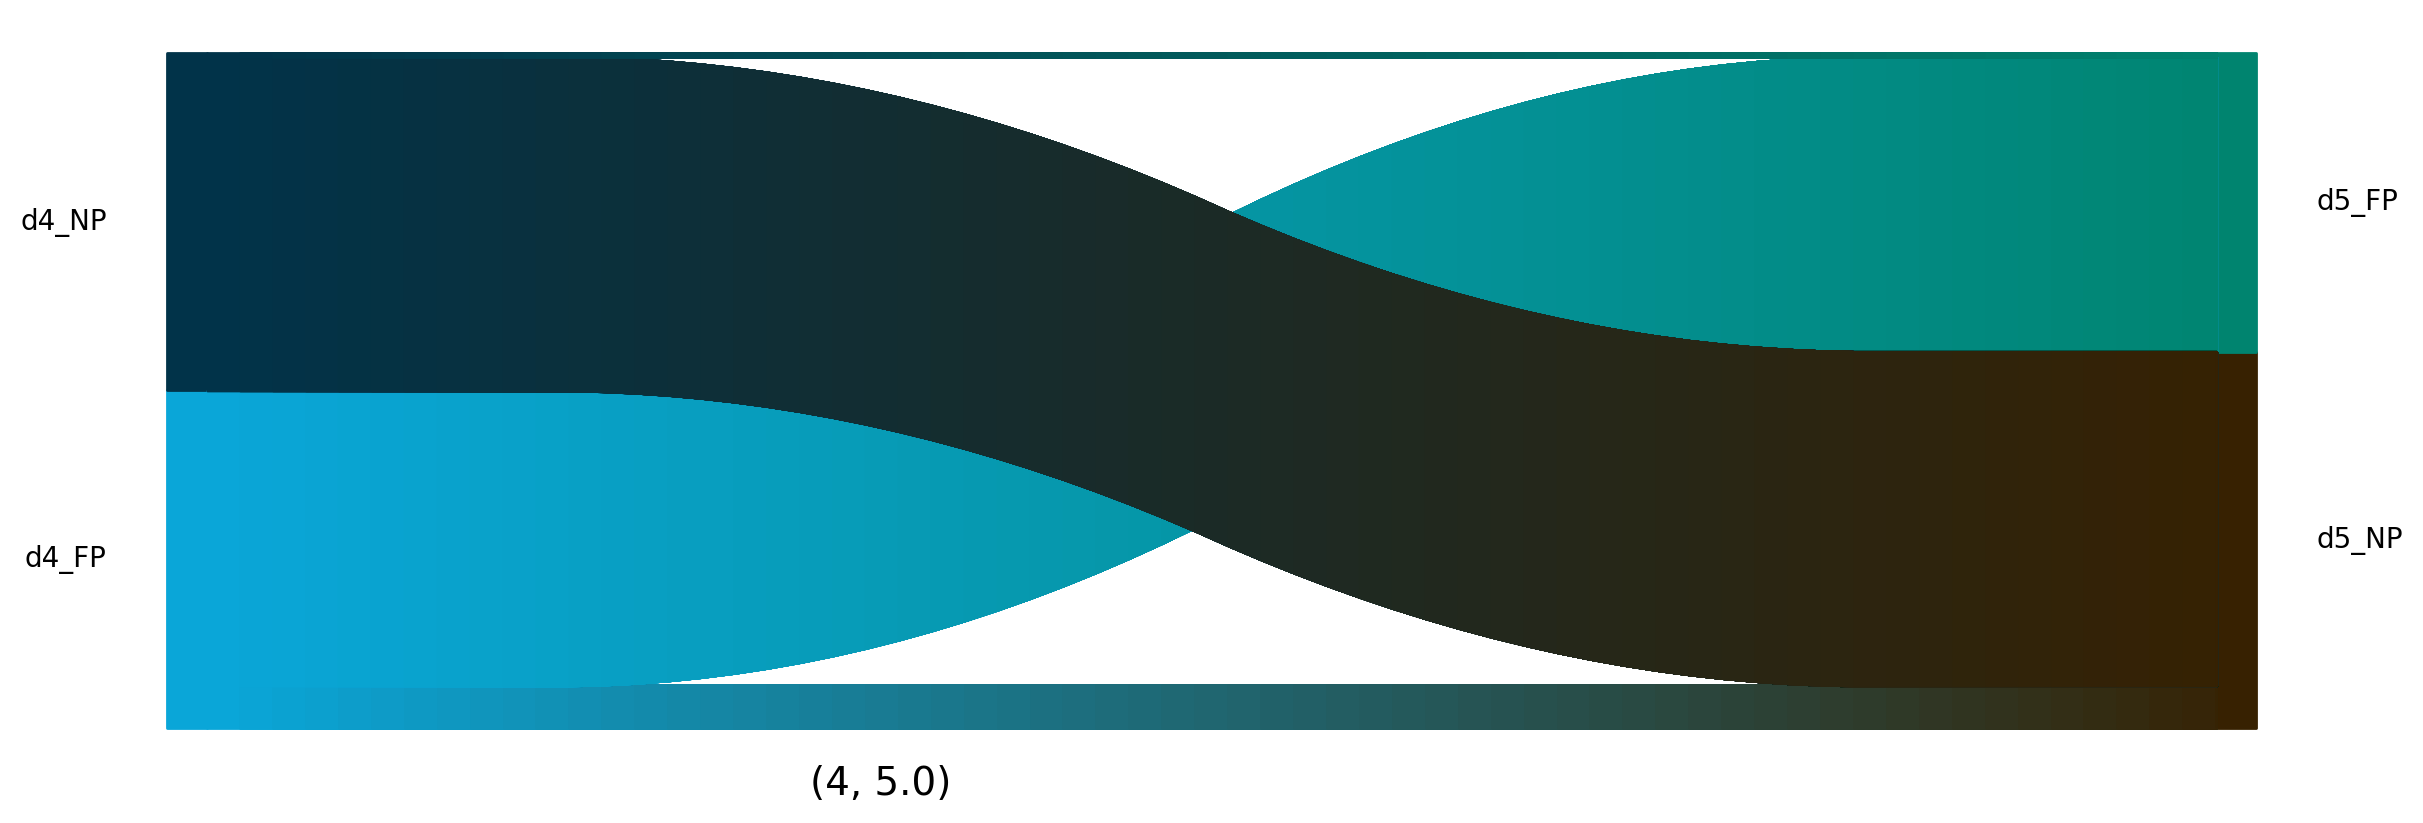

In [24]:
mpl.sankey(tp0, dpi=100, figsize=(12, 4), fontsize=10, interpolate_color=True)

In [25]:
tp0.sankey(
    source=2,
    target=2.5,
    source_groups={"metacell_label": d2_cluster},
    target_groups={"metacell_label": d2_5_cluster},
    threshold=0.0,
    #order_annotations=cluster_subset[::-1],
    normalize=True,
)

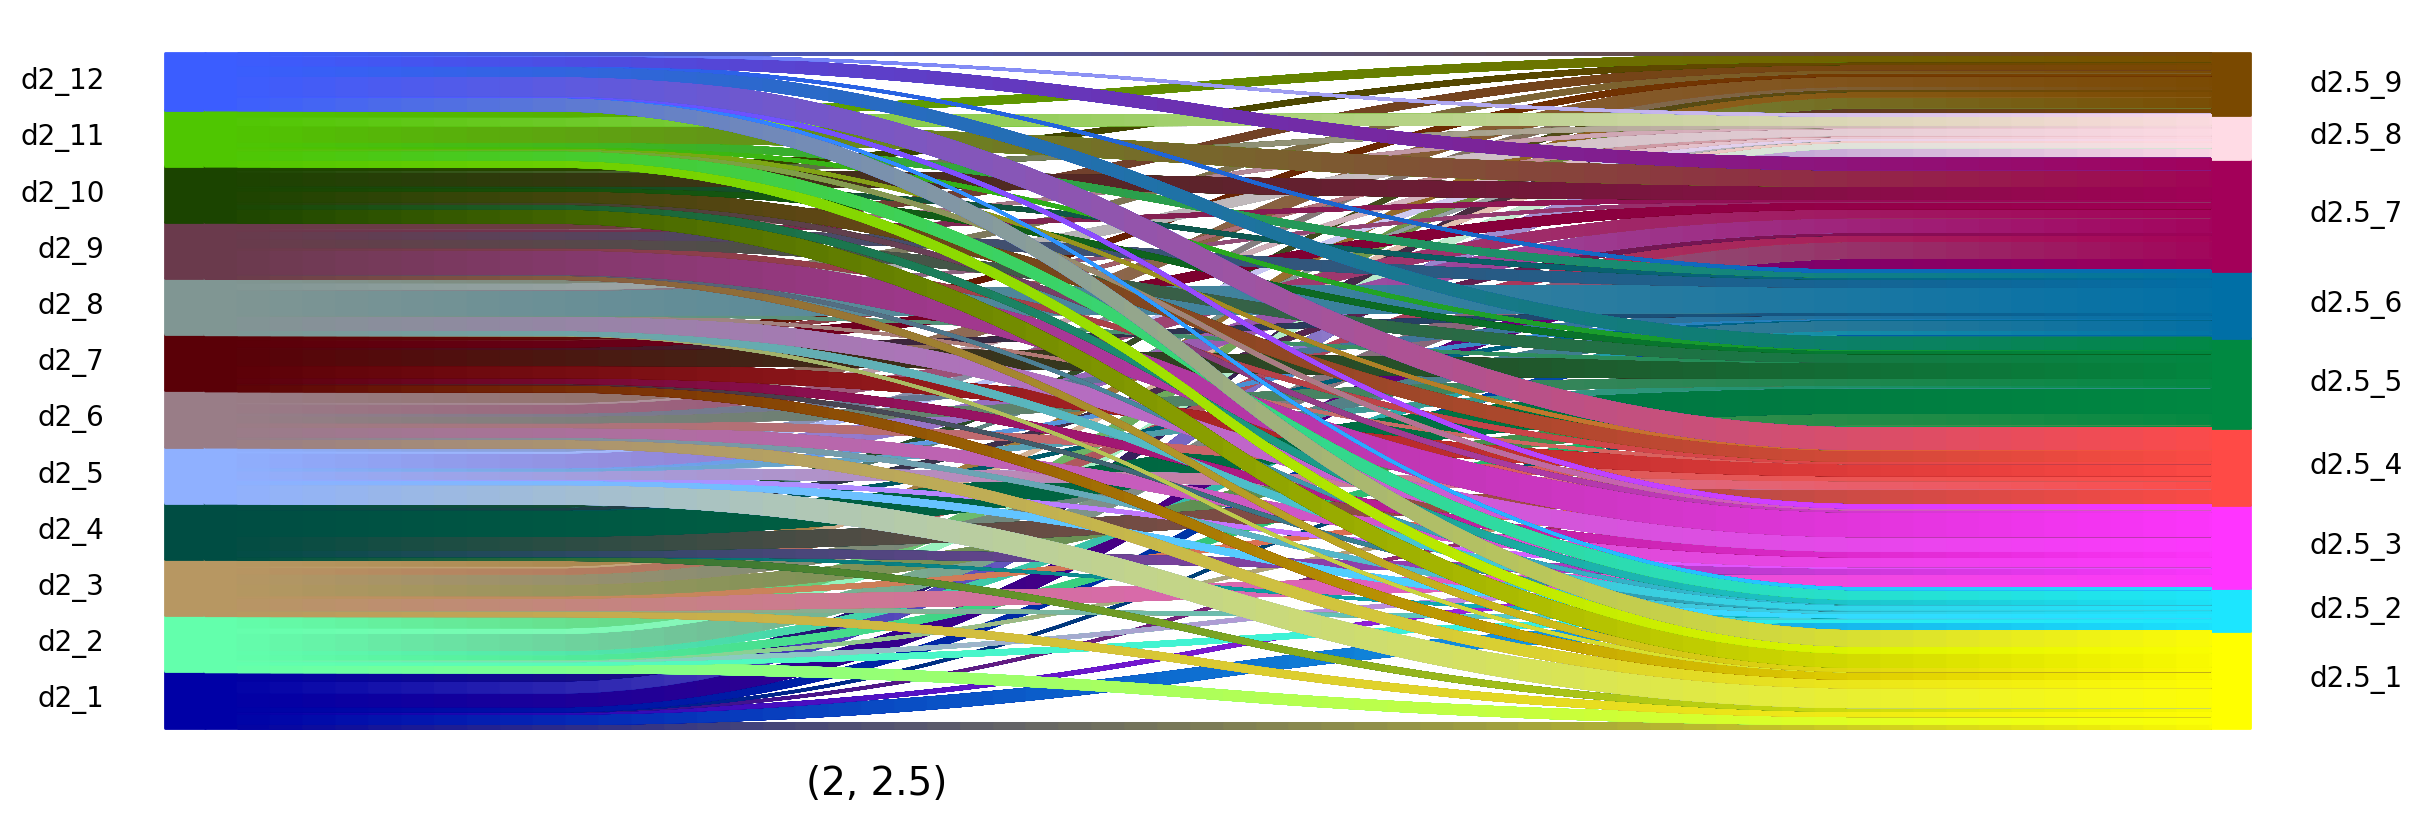

In [26]:
mpl.sankey(tp0, dpi=100, figsize=(12, 4), fontsize=10, interpolate_color=True)

In [27]:
ct_desc = tp0.cell_transition(
    4,
    5,
    {"metacell_label": d4_cluster},
    {"metacell_label": d5_cluster},
    forward=False,
    key_added="transitions_4_5_large",
)

In [28]:
tp0.cell_transition(
    source=2,
    target=5,
    source_groups="metacell_label",
    target_groups="metacell_label",
    forward=True,
    key_added="cell_transition",
)

,d5_NP,d5_FP
d2_12,0.480531,0.519469
d2_3,0.579455,0.420545
d2_8,0.516969,0.483031
d2_6,0.571625,0.428375
d2_4,0.562274,0.437726
d2_2,0.545726,0.454274
d2_11,0.497637,0.502363
d2_10,0.494907,0.505093
d2_1,0.495165,0.504835
d2_5,0.501698,0.498302


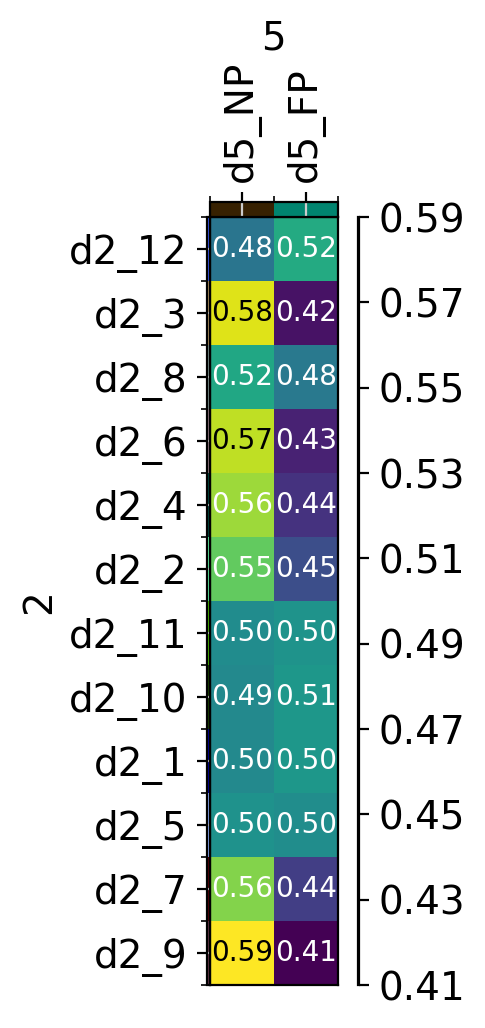

In [29]:
mpl.cell_transition(tp0, dpi=100, fontsize=10, key="cell_transition")

In [30]:
tp0.cell_transition(
    source=2.5,
    target=5,
    source_groups="metacell_label",
    target_groups="metacell_label",
    forward=True,
    key_added="cell_transition",
)

,d5_NP,d5_FP
d2.5_9,0.634938,0.365062
d2.5_6,0.522788,0.477212
d2.5_2,0.431254,0.568746
d2.5_5,0.667007,0.332993
d2.5_1,0.509900,0.490100
d2.5_7,0.530078,0.469922
d2.5_8,0.456140,0.543860
d2.5_4,0.367708,0.632292
d2.5_3,0.600095,0.399905


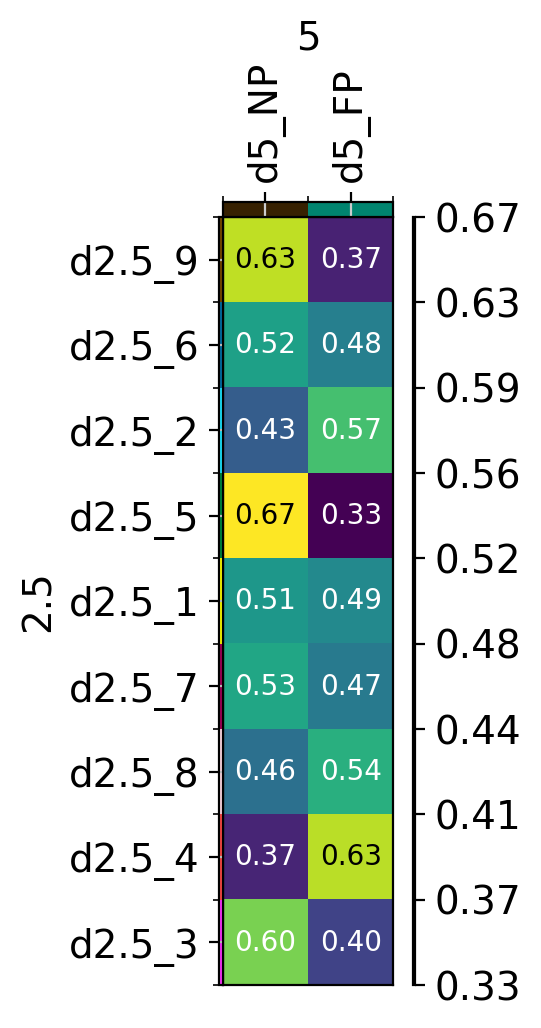

In [31]:
mpl.cell_transition(tp0, dpi=100, fontsize=10, key="cell_transition")

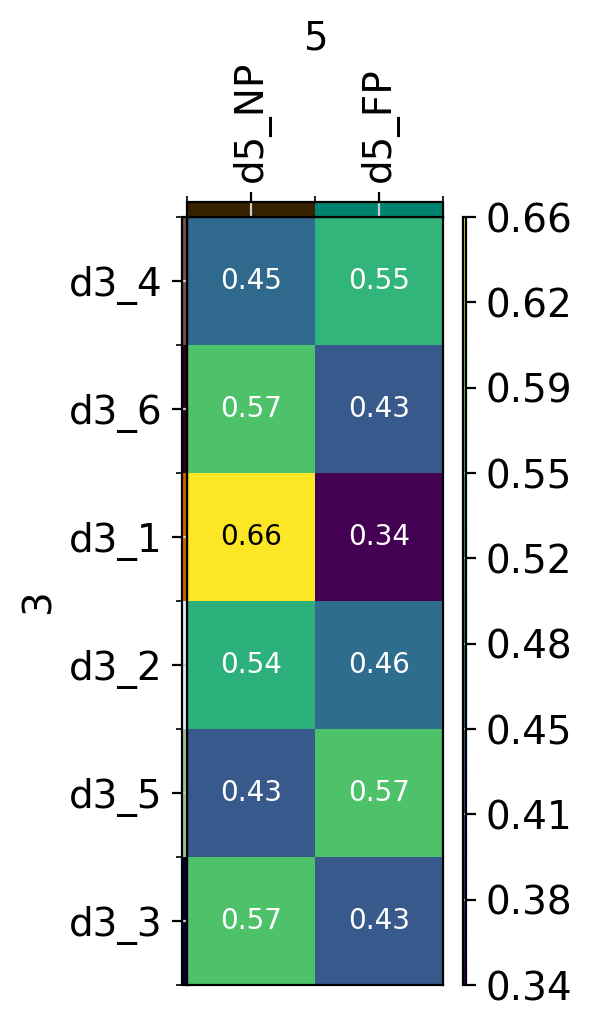

In [32]:
tp0.cell_transition(
    source=3,
    target=5,
    source_groups="metacell_label",
    target_groups="metacell_label",
    forward=True,
    key_added="cell_transition",
)
mpl.cell_transition(tp0, dpi=100, fontsize=10, key="cell_transition")

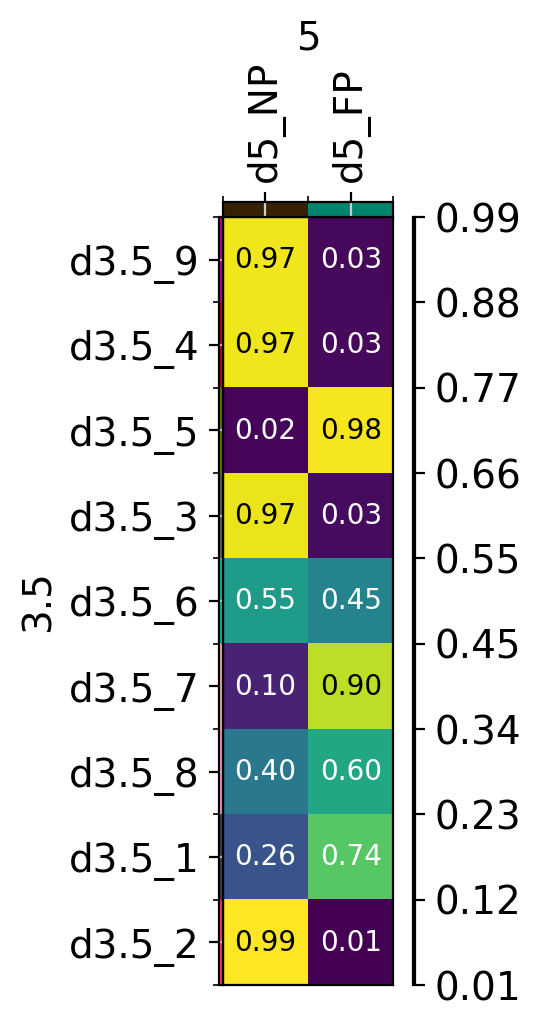

In [33]:
tp0.cell_transition(
    source=3.5,
    target=5,
    source_groups="metacell_label",
    target_groups="metacell_label",
    forward=True,
    key_added="cell_transition",
)
mpl.cell_transition(tp0, dpi=100, fontsize=10, key="cell_transition")

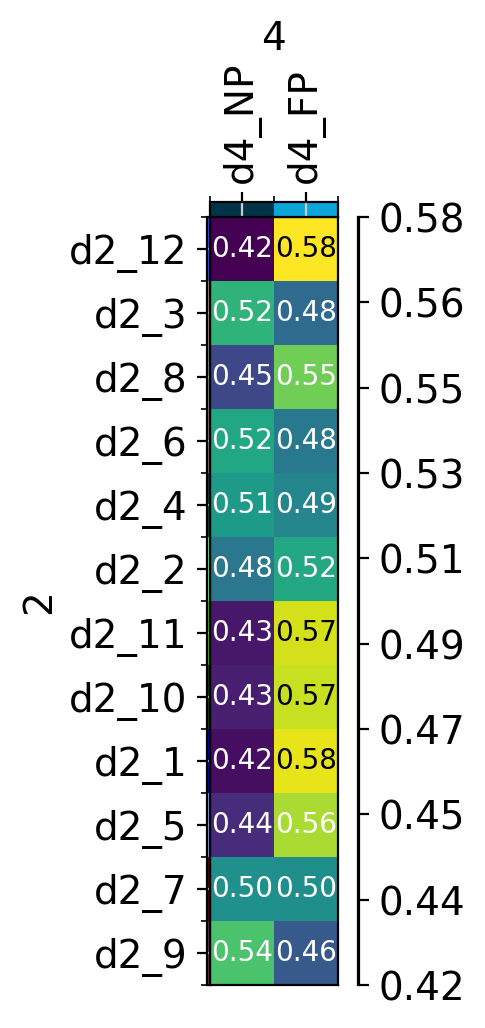

In [34]:
tp0.cell_transition(
    source=2,
    target=4,
    source_groups="metacell_label",
    target_groups="metacell_label",
    forward=True,
    key_added="cell_transition",
)
mpl.cell_transition(tp0, dpi=100, fontsize=10, key="cell_transition")

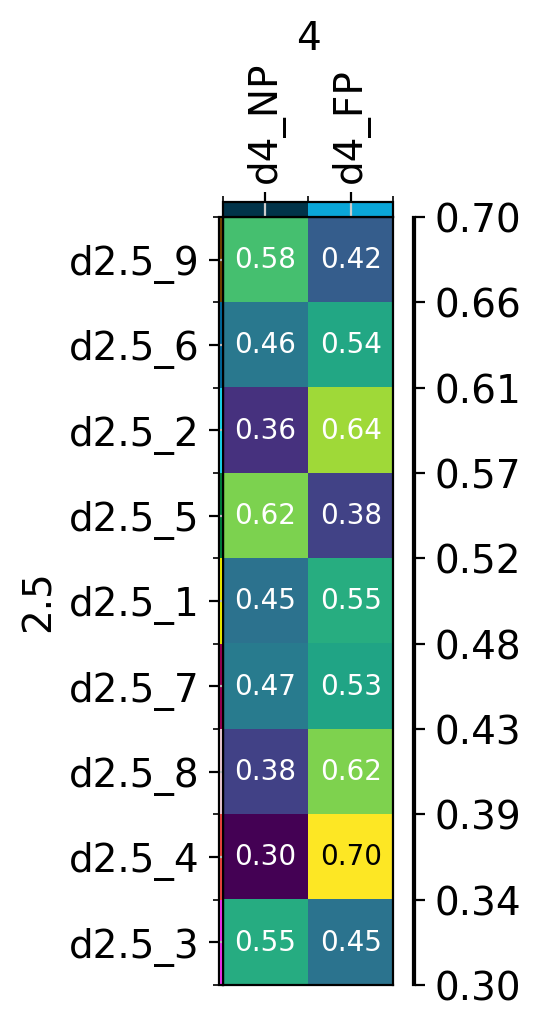

In [35]:
tp0.cell_transition(
    source=2.5,
    target=4,
    source_groups="metacell_label",
    target_groups="metacell_label",
    forward=True,
    key_added="cell_transition",
)
mpl.cell_transition(tp0, dpi=100, fontsize=10, key="cell_transition")

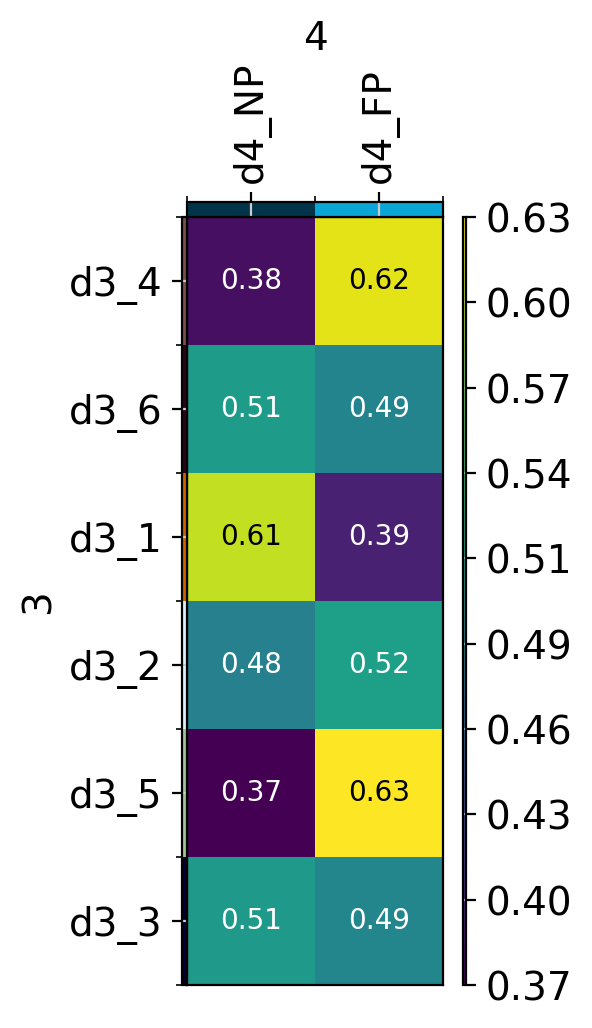

In [36]:
tp0.cell_transition(
    source=3,
    target=4,
    source_groups="metacell_label",
    target_groups="metacell_label",
    forward=True,
    key_added="cell_transition",
)
mpl.cell_transition(tp0, dpi=100, fontsize=10, key="cell_transition")

In [37]:
tp0.sankey(
    source=2,
    target=5,
    source_groups="metacell_label",
    target_groups="metacell_label",
    forward=True,
)

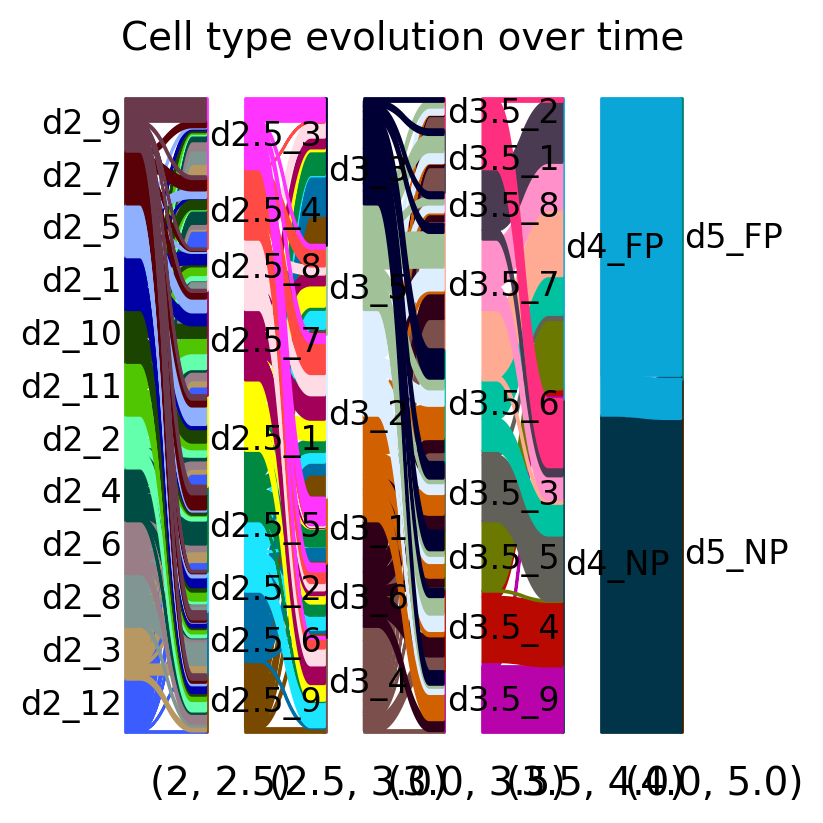

In [38]:
mpl.sankey(tp0, dpi=100, title="Cell type evolution over time")

In [ ]:
color_dict = {
    "Prlf. Ductal": "#f7b6d2",
    "Ductal": "#d62728",
    "Imm. Acinar": "#ffeb3b",
    "Mat. Acinar": "#98df8a",
    "Alpha": "#1f77b4",
    "Beta": "#ff7f0e",
    "Delta": "#279e68",
    "Eps. progenitors": "#aa40fc",
    "Epsilon": "#8c564b",
    "Fev+": "#e377c2",
    "Fev+ Alpha": "#b5bd61",
    "Fev+ Beta": "#42f5ec",
    "Fev+ Delta": "#aec7e8",
    "Fev+ Delta,0": "#17becf",
    "Fev+ Delta,1": "#98df8a",
    "Ngn3 high cycling": "#adf542",
    "Ngn3 high,0": "#ff9896",
    "Ngn3 high": "#ff9896",
    "Ngn3 high,1": "#f0b98d",
    "Ngn3 low": "#c5b0d5",
}
tp0.adata.uns["cell_type_refined_colors"] = [
    color_dict[ct] for ct in tp0.adata.obs["cell_type_refined"].cat.categories
]

In [ ]:
mpl.sankey(tp0, dpi=100, figsize=(12, 4), fontsize=10, interpolate_color=True)